# Imports

In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.optimize import curve_fit
from prettytable import PrettyTable

import xml.etree.ElementTree as ET

# Load in data

In [2]:
# path = os.path.join(os.getcwd(), 'data', 'apple_health_export/')
filename = 'apple_health_export/export.xml'

tree = ET.parse(filename) 
root = tree.getroot()
# record_list = [x.attrib for x in root.iter('Record')]

In [3]:
# print all the elements 
data_types = set()

for elem in root.iter():
    data_types.add(elem.tag)

print(data_types)

{'HeartRateVariabilityMetadataList', 'MetadataEntry', 'FileReference', 'HealthData', 'Me', 'ActivitySummary', 'WorkoutRoute', 'Record', 'WorkoutStatistics', 'WorkoutEvent', 'ExportDate', 'InstantaneousBeatsPerMinute', 'Workout'}


In [4]:
# Function to load data from root into a pandas dataframe
def load_dataframe(type):
    return pd.DataFrame([x.attrib for x in root.iter(type)])

## Record data

In [ ]:
record_data = load_dataframe('Record')

# proper type to dates
for col in ['creationDate', 'startDate', 'endDate']:
    record_data[col] = pd.to_datetime(record_data[col])

# value is numeric, NaN if fails
record_data['value'] = pd.to_numeric(record_data['value'], errors='coerce')

# some records do not measure anything, just count occurences
# filling with 1.0 (= one time) makes it easier to aggregate
record_data['value'] = record_data['value'].fillna(1.0)

# shorter observation names
record_data['type'] = record_data['type'].str.replace('HKQuantityTypeIdentifier', '')
record_data['type'] = record_data['type'].str.replace('HKCategoryTypeIdentifier', '')
record_data.tail()

## Workout data

In [5]:
workout_list = [x.attrib for x in root.iter('Workout')]

# create DataFrame
workout_data = pd.DataFrame(workout_list)
workout_data['workoutActivityType'] = workout_data['workoutActivityType'].str.replace('HKWorkoutActivityType', '')
workout_data = workout_data.rename({"workoutActivityType": "Type"}, axis=1)

# # proper type to dates
# for col in ['creationDate', 'startDate', 'endDate']:
#     workout_data[col] = pd.to_datetime(workout_data[col])

# # convert string to numeric   
# workout_data['duration'] = pd.to_numeric(workout_data['duration'])
# workout_data['totalEnergyBurned'] = pd.to_numeric(workout_data['totalEnergyBurned'])
# workout_data['totalDistance'] = pd.to_numeric(workout_data['totalDistance'])
# workout_data.tail()

In [ ]:
print(data_types)

{'HealthData', 'WorkoutStatistics', 'Me', 'HeartRateVariabilityMetadataList', 'WorkoutEvent', 'WorkoutRoute', 'MetadataEntry', 'ExportDate', 'FileReference', 'InstantaneousBeatsPerMinute', 'Record', 'ActivitySummary', 'Workout'}


In [8]:
df = load_dataframe('ActivitySummary')
df

,dateComponents,activeEnergyBurned,activeEnergyBurnedGoal,activeEnergyBurnedUnit,appleMoveTime,appleMoveTimeGoal,appleExerciseTime,appleExerciseTimeGoal,appleStandHours,appleStandHoursGoal
0,2021-05-13,0,0,Cal,0,0,0,30,0,12
1,2021-05-14,3.141,0,Cal,0,0,0,30,0,12
2,2021-07-11,0,0,Cal,0,0,0,30,0,12
3,2021-07-12,480.135,650,Cal,0,0,63,45,4,6
4,2021-07-13,1421.75,650,Cal,0,0,142,45,15,6
...,...,...,...,...,...,...,...,...,...,...
1234,2025-01-03,21.294,1200,Cal,0,0,0,90,1,8
1235,2025-01-04,738.345,1200,Cal,0,0,89,90,10,8
1236,2025-01-05,774.433,1200,Cal,0,0,95,90,7,8
1237,2025-01-06,1071.38,1200,Cal,0,0,127,90,13,8


In [9]:
activeCals = df.activeEnergyBurned.astype(float)
print("Total calories burned since I got the watch: ", activeCals.sum())

Total calories burned since I got the watch:  1193269.0470999999


In [14]:
df.head()

,dateComponents,activeEnergyBurned,activeEnergyBurnedGoal,activeEnergyBurnedUnit,appleMoveTime,appleMoveTimeGoal,appleExerciseTime,appleExerciseTimeGoal,appleStandHours,appleStandHoursGoal
0,2021-05-13,0,0,Cal,0,0,0,30,0,12
1,2021-05-14,3.141,0,Cal,0,0,0,30,0,12
2,2021-07-11,0,0,Cal,0,0,0,30,0,12
3,2021-07-12,480.135,650,Cal,0,0,63,45,4,6
4,2021-07-13,1421.75,650,Cal,0,0,142,45,15,6


In [17]:
# num_days = df.dateComponents.nunique()
averageCalsBurnedPerDay = activeCals.sum() / num_days 
print("Average calories burned per day: ", averageCalsBurnedPerDay)

Average calories burned per day:  893.8344922097377


In [ ]:
50000 / averageCalsBurnedPerDay

56.2011322664314

In [16]:
dates = pd.to_datetime(df.dateComponents)
days = dates.iloc[-1] - dates.iloc[0]
num_days = days.days
print(num_days)

1335


In [18]:
len(df) / num_days  *100

92.80898876404494

In [19]:
903 / len(df)  * 100

72.88135593220339

In [21]:
df = load_dataframe('Workout')
df

,workoutActivityType,duration,durationUnit,sourceName,sourceVersion,device,creationDate,startDate,endDate
0,HKWorkoutActivityTypeWalking,12.87223668297132,min,Adam’s Apple Watch,7.5,"<<HKDevice: 0x300e8e080>, name:Apple Watch, ma...",2021-07-13 10:23:53 -0500,2021-07-13 10:11:00 -0500,2021-07-13 10:23:53 -0500
1,HKWorkoutActivityTypeDiscSports,55.56390554904938,min,Adam’s Apple Watch,7.5,"<<HKDevice: 0x300e8e080>, name:Apple Watch, ma...",2021-07-13 17:33:24 -0500,2021-07-13 16:37:49 -0500,2021-07-13 17:33:23 -0500
2,HKWorkoutActivityTypeRunning,1.410094485680262,min,Adam’s Apple Watch,7.5,"<<HKDevice: 0x300e8e080>, name:Apple Watch, ma...",2021-07-13 17:37:48 -0500,2021-07-13 17:35:35 -0500,2021-07-13 17:37:47 -0500
3,HKWorkoutActivityTypeTraditionalStrengthTraining,56.02488265236219,min,Adam’s Apple Watch,7.5,"<<HKDevice: 0x300e8e080>, name:Apple Watch, ma...",2021-07-13 19:23:46 -0500,2021-07-13 18:20:27 -0500,2021-07-13 19:23:45 -0500
4,HKWorkoutActivityTypeWalking,16.15754281679789,min,Adam’s Apple Watch,7.5,"<<HKDevice: 0x300e8e080>, name:Apple Watch, ma...",2021-07-14 10:04:12 -0500,2021-07-14 09:48:02 -0500,2021-07-14 10:04:12 -0500
...,...,...,...,...,...,...,...,...,...
1209,HKWorkoutActivityTypeHockey,73.29818121592204,min,Adam’s Apple Watch,10.6.1,"<<HKDevice: 0x300d90500>, name:Apple Watch, ma...",2024-12-27 22:43:37 -0500,2024-12-27 21:30:12 -0500,2024-12-27 22:43:30 -0500
1210,HKWorkoutActivityTypeTraditionalStrengthTraining,50.71759476661682,min,Adam’s Apple Watch,10.6.1,"<<HKDevice: 0x300d90500>, name:Apple Watch, ma...",2024-12-28 10:17:27 -0500,2024-12-28 09:26:38 -0500,2024-12-28 10:17:21 -0500
1211,HKWorkoutActivityTypeTraditionalStrengthTraining,85.579724051555,min,Adam’s Apple Watch,10.6.1,"<<HKDevice: 0x300d90500>, name:Apple Watch, ma...",2025-01-05 16:14:11 -0500,2025-01-05 14:48:26 -0500,2025-01-05 16:14:01 -0500
1212,HKWorkoutActivityTypeWalking,32.11453287601471,min,Adam’s Apple Watch,10.6.1,"<<HKDevice: 0x300d90500>, name:Apple Watch, ma...",2025-01-06 16:19:10 -0500,2025-01-06 15:46:57 -0500,2025-01-06 16:19:04 -0500


In [ ]:
# types of statistics 
stat_types = df['type'].unique()
print(stat_types)

['HKQuantityTypeIdentifierActiveEnergyBurned'
 'HKQuantityTypeIdentifierDistanceWalkingRunning'
 'HKQuantityTypeIdentifierBasalEnergyBurned'
 'HKQuantityTypeIdentifierHeartRate' 'HKQuantityTypeIdentifierStepCount'
 'HKQuantityTypeIdentifierRunningGroundContactTime'
 'HKQuantityTypeIdentifierRunningPower'
 'HKQuantityTypeIdentifierRunningVerticalOscillation'
 'HKQuantityTypeIdentifierRunningSpeed'
 'HKQuantityTypeIdentifierRunningStrideLength'
 'HKQuantityTypeIdentifierDistanceCycling']


In [22]:
df = load_dataframe('Workout')
workout_types = df['workoutActivityType'].str.replace('HKWorkoutActivityType', '').unique()
print(workout_types)

['Walking' 'DiscSports' 'Running' 'TraditionalStrengthTraining' 'Yoga'
 'TableTennis' 'Other' 'CoreTraining' 'Tennis' 'Golf' 'Hiking'
 'HighIntensityIntervalTraining' 'SkatingSports' 'Cycling' 'Rowing'
 'Volleyball' 'Soccer' 'FunctionalStrengthTraining' 'Squash'
 'AmericanFootball' 'Hockey' 'Cooldown' 'Basketball' 'CardioDance' 'Rugby']


# Building full workout dataframe 

This issue here is that workout types, start, and end dates are saved in "Workout" but the calorie data, distance run, etc. is all saved in "WorkoutStatistics", so I need to figure out how to merge these two datasets. The best way to do this is to align the start and end times. 

In [23]:
workouts = load_dataframe('Workout')
stats = load_dataframe('WorkoutStatistics')
activity = load_dataframe('ActivitySummary')

In [24]:
stats.columns

Index(['type', 'startDate', 'endDate', 'sum', 'unit', 'average', 'minimum',
       'maximum'],
      dtype='object')

In [25]:
# start out with the workouts dataframe 
df = workouts.copy()

# convert dates to datetime object 
for col in ['creationDate', 'startDate', 'endDate']:
    df[col] = pd.to_datetime(df[col])

for col in ["startDate", "endDate"]:
    stats[col] = pd.to_datetime(stats[col])

# drop the unnecessary columns
df.drop(columns=['sourceName', 'sourceVersion', 'device'], inplace=True)

# create a new column with clean workout type 
df['Type'] = df['workoutActivityType'].str.replace('HKWorkoutActivityType', '')

# change name of all the type elements to remove HKQuantityTypeIdentifier
stats['type'] = stats['type'].str.replace('HKQuantityTypeIdentifier', '')

In [26]:
# provides safe access to data that may not exist
def access(call):
    try: 
        return call()
    except:
        return np.nan

In [27]:
statistics_columns = ["activeCalories", "basalCalories", "distance", "avgHeartRate", "minHeartRate", "maxHeartRate", "avgRunSpeed", "minRunSpeed", "maxRunSpeed"]
statistics = []

for i in range(len(df)):
    workout = df.iloc[i]
    start = workout.startDate

    recordedStats = stats[stats.startDate == start]

    # Create np.nans if no data is available for a workout 
    if len(recordedStats) == 0:
        workout_stats =  [np.nan] * len(statistics_columns)

    else:
        activeCalories = access(lambda: recordedStats.loc[recordedStats["type"] == "ActiveEnergyBurned"]["sum"].values[0])
        basalCalories = access(lambda: recordedStats.loc[recordedStats["type"] == "BasalEnergyBurned"]["sum"].values[0])
        distance = access(lambda: recordedStats.loc[recordedStats["type"] == "DistanceWalkingRunning"]["sum"].values[0])
        avgHeartRate = access(lambda: recordedStats.loc[recordedStats["type"] == "HeartRate"]["average"].values[0])
        minHeartRate = access(lambda: recordedStats.loc[recordedStats["type"] == "HeartRate"]["minimum"].values[0])
        maxHeartRate = access(lambda: recordedStats.loc[recordedStats["type"] == "HeartRate"]["maximum"].values[0])
        avgSpeed = access(lambda: recordedStats.loc[recordedStats["type"] == "RunningSpeed"]["average"].values[0])
        minSpeed = access(lambda: recordedStats.loc[recordedStats["type"] == "RunningSpeed"]["minimum"].values[0])
        maxSpeed = access(lambda: recordedStats.loc[recordedStats["type"] == "RunningSpeed"]["maximum"].values[0])
 
        workout_stats = [activeCalories, basalCalories, distance, avgHeartRate, minHeartRate, maxHeartRate, avgSpeed, minSpeed, maxSpeed]

    statistics.append(workout_stats)

# add to datafram 
statistics = np.array(statistics)

for i, col in enumerate(statistics_columns):
    df[col] = statistics[:,i]


In [28]:
numeric_columns = ["duration", "activeCalories", "basalCalories", "distance", "avgHeartRate", "minHeartRate", "maxHeartRate", "avgRunSpeed", "minRunSpeed", "maxRunSpeed"]

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [29]:
df['totalCalories'] = df['activeCalories'] + df['basalCalories']

In [40]:
df.columns

Index(['workoutActivityType', 'duration', 'durationUnit', 'creationDate',
       'startDate', 'endDate', 'Type', 'activeCalories', 'basalCalories',
       'distance', 'avgHeartRate', 'minHeartRate', 'maxHeartRate',
       'avgRunSpeed', 'minRunSpeed', 'maxRunSpeed', 'totalCalories'],
      dtype='object')

# Analysis

## Average Monthly calories burned 

In [30]:
# compute and plot the average active calories burned per week 
data = df.copy()
data = data[["creationDate", "duration", "avgHeartRate", "activeCalories", "basalCalories"]]

In [31]:
data.set_index('creationDate', inplace=True)

In [32]:
data['totalCalories'] = data['activeCalories'] + data['basalCalories']

In [33]:
data = data.fillna(0)

In [34]:
monthly_total = data['totalCalories'].resample('M').sum()
monthly_active = data['activeCalories'].resample('M').sum()

In [35]:
df.Type.unique()

array(['Walking', 'DiscSports', 'Running', 'TraditionalStrengthTraining',
       'Yoga', 'TableTennis', 'Other', 'CoreTraining', 'Tennis', 'Golf',
       'Hiking', 'HighIntensityIntervalTraining', 'SkatingSports',
       'Cycling', 'Rowing', 'Volleyball', 'Soccer',
       'FunctionalStrengthTraining', 'Squash', 'AmericanFootball',
       'Hockey', 'Cooldown', 'Basketball', 'CardioDance', 'Rugby'],
      dtype=object)

In [36]:
# get tennis and gym only 
tennis = df.loc[df.Type=="Tennis"]
gym = df.loc[(df.Type=="TraditionalStrengthTraining") |  (df.Type == "FunctionalStrengthTraining")]
running = df.loc[df.Type=="Running"]

tennis = tennis[["creationDate", "duration", "avgHeartRate", "activeCalories", "basalCalories"]]
gym = gym[["creationDate", "duration", "avgHeartRate", "activeCalories", "basalCalories"]]
running = running[["creationDate", "duration", "avgHeartRate", "activeCalories", "basalCalories"]]

tennis.set_index('creationDate', inplace=True)
gym.set_index('creationDate', inplace=True)
running.set_index('creationDate', inplace=True)

tennis["totalCalories"] = tennis["activeCalories"] + tennis["basalCalories"]
gym["totalCalories"] = gym["activeCalories"] + gym["basalCalories"]
running["totalCalories"] = running["activeCalories"] + running["basalCalories"]

tennis = tennis.fillna(0)
gym = gym.fillna(0)
running = running.fillna(0)

monthly_tennis = tennis['totalCalories'].resample('M').sum()
monthly_gym = gym['totalCalories'].resample('M').sum()
monthly_run = running['totalCalories'].resample('M').sum()

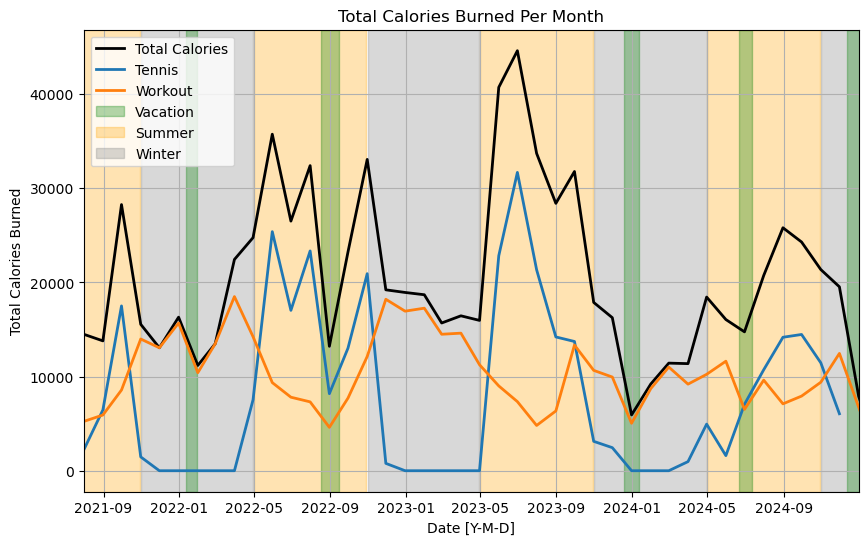

In [44]:
# Plotting the total calories burned per week
plt.figure(figsize=(10, 6))
plt.plot(monthly_total, color='k', lw=2, label="Total Calories")
plt.plot(monthly_tennis, color='C0', lw=2, label="Tennis")
plt.plot(monthly_gym, color='C1', lw=2, label="Workout")
# plt.plot(monthly_run, color='C3', lw=2, label="Running")

for year in range(2021, 2025):
    plt.axvspan(pd.Timestamp(f'{year}-05-01'), pd.Timestamp(f'{year}-10-30'), color='orange', alpha=0.3)

for year in range(2021, 2025):
    next_year = year+1
    plt.axvspan(pd.Timestamp(f'{year}-11-01'), pd.Timestamp(f'{next_year}-04-30'), color='gray', alpha=0.3)

plt.axvspan(pd.Timestamp('2022-01-12'), pd.Timestamp('2022-01-30'), color='green', alpha=0.3, label="Vacation")
plt.axvspan(pd.Timestamp('2022-08-18'), pd.Timestamp('2022-09-15'), color='green', alpha=0.3)
plt.axvspan(pd.Timestamp('2023-12-19'), pd.Timestamp('2024-01-12'), color='green', alpha=0.3)
plt.axvspan(pd.Timestamp('2024-06-22'), pd.Timestamp('2024-07-12'), color='green', alpha=0.3)
plt.axvspan(pd.Timestamp('2024-12-12'), pd.Timestamp('2025-01-06'), color='green', alpha=0.3)

plt.axvspan(np.nan, np.nan, color='orange', alpha=0.3, label="Summer")
plt.axvspan(np.nan, np.nan, color='gray', alpha=0.3, label="Winter")

plt.title('Total Calories Burned Per Month')
plt.xlabel('Date [Y-M-D]')
plt.ylabel('Total Calories Burned')
plt.grid(True)
plt.legend()
plt.xlim(monthly_total.index[0], monthly_total.index[-2])
plt.savefig("plots/2024/total_calories.pdf")
plt.show()

In [45]:
monthly_total.index[-2]

Timestamp('2024-12-31 00:00:00-0500', tz='UTC-05:00')

## Step count

In [150]:
data = stats.copy()
data.loc[data.type == "StepCount"]["sum"]

1520       3653
1546    2357.09
1590    3903.88
1609       3554
1881       2364
2042       2099
2078    3035.32
2100       3808
2517       4733
2921       2983
Name: sum, dtype: object

# Data Exploration

## Frequency of sports

In [77]:
# count the total number of each workout type
exercises.size().sort_values(ascending=False)

Type
TraditionalStrengthTraining      501
Tennis                           226
Walking                          100
Cycling                           44
Running                           25
Soccer                            18
Hockey                            14
Rowing                            13
Other                              7
Squash                             7
Golf                               6
Volleyball                         5
TableTennis                        5
DiscSports                         5
FunctionalStrengthTraining         3
Cooldown                           2
Basketball                         2
Yoga                               2
HighIntensityIntervalTraining      2
AmericanFootball                   1
CoreTraining                       1
CardioDance                        1
SkatingSports                      1
Hiking                             1
Rugby                              1
dtype: int64

In [74]:
# Number of hours spent in each workout type
exercises['duration'].sum().sort_values(ascending=False) / 60 # in hours
# exercises['duration'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))

Type
TraditionalStrengthTraining      589.674132
Tennis                           357.893398
Walking                           59.492688
Golf                              21.088001
Soccer                            16.348095
Cycling                           14.425501
Hockey                            10.822390
Squash                             7.862073
Running                            7.768482
Volleyball                         7.385045
DiscSports                         3.956234
Other                              3.617737
Rowing                             2.318415
FunctionalStrengthTraining         2.208700
TableTennis                        1.996121
CardioDance                        1.840610
SkatingSports                      1.557993
Rugby                              1.532623
Basketball                         1.374869
Hiking                             1.357746
Yoga                               1.170559
Cooldown                           0.754878
AmericanFootball           

In [75]:
# average length of each workout type
exercises['duration'].mean().sort_values(ascending=False) / 60 # in hours

Type
Golf                             3.514667
CardioDance                      1.840610
Tennis                           1.583599
SkatingSports                    1.557993
Rugby                            1.532623
Volleyball                       1.477009
Hiking                           1.357746
TraditionalStrengthTraining      1.176994
Squash                           1.123153
Soccer                           0.908227
DiscSports                       0.791247
Hockey                           0.773028
FunctionalStrengthTraining       0.736233
Basketball                       0.687434
AmericanFootball                 0.685367
Walking                          0.594927
Yoga                             0.585280
Other                            0.516820
TableTennis                      0.399224
Cooldown                         0.377439
Cycling                          0.327852
Running                          0.310739
HighIntensityIntervalTraining    0.304329
Rowing                       

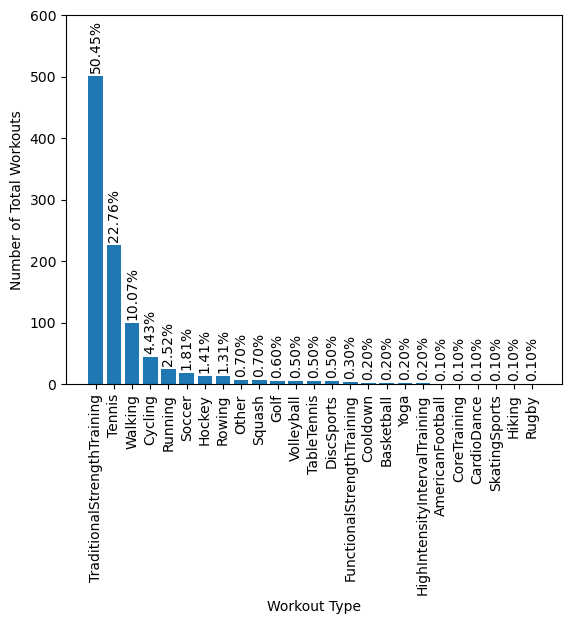

In [80]:
# frequency as a percentage of total workouts
data = exercises.size().sort_values(ascending=False)
plt.bar(data.index, data.values)
# label the bars with the percent of total workouts
for i, v in enumerate(data.values):
    plt.text(i, v + 10, f"{v / len(df) * 100:.2f}%", ha='center', rotation=90)
plt.xlabel('Workout Type')
plt.ylabel('Number of Total Workouts')
plt.xticks(rotation=90)
plt.ylim(0, data.values.max() + 100)

plt.show()

## Highest calorie burning exercises

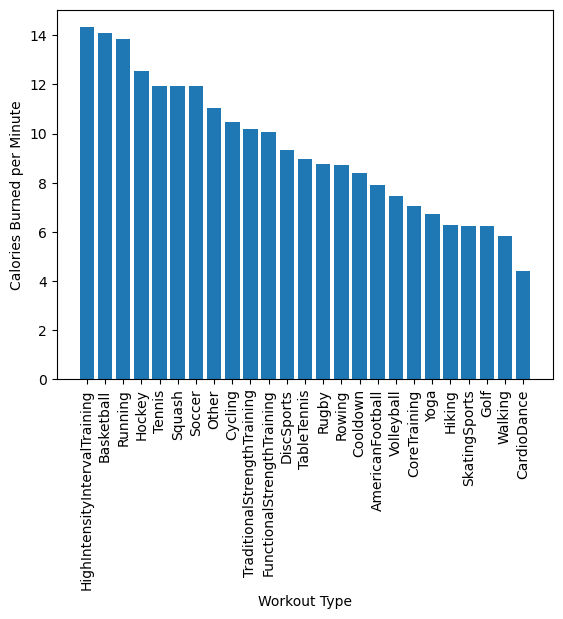

In [85]:
# find the calories burned per minute for each workout type
calorieperduration = df.groupby('Type')['totalCalories'].sum() / df.groupby('Type')['duration'].sum()
# basalperduration = df.groupby('Type')['basalCalories'].sum() / df.groupby('Type')['duration'].sum()

calorieperduration = calorieperduration.sort_values(ascending=False)
# basalperduration = basalperduration.sort_values(ascending=False)

plt.bar(calorieperduration.index, calorieperduration.values, label="Total")
# plt.bar(basalperduration.index, basalperduration.values, label='Basal')
# # label the bars with the percent of total workouts
# for i, v in enumerate(exercises.size().values):
#     plt.text(i, v + 10, f"{v / len(df) * 100:.2f}%", ha='center', rotation=90)
plt.xlabel('Workout Type')
plt.ylabel('Calories Burned per Minute')
plt.xticks(rotation=90)
# plt.legend()

plt.show()

In [86]:
df.groupby('Type')['totalCalories'].sum().sort_values(ascending=False)

Type
TraditionalStrengthTraining      359897.11705
Tennis                           256402.09370
Walking                           20867.24723
Soccer                            11692.09080
Cycling                            9078.42961
Hockey                             8146.33390
Golf                               7883.82420
Running                            6455.34368
Squash                             5628.25730
Volleyball                         3310.19630
Other                              2394.01950
DiscSports                         2213.18810
FunctionalStrengthTraining         1332.76192
Rowing                             1213.65406
Basketball                         1161.81960
TableTennis                        1076.24000
Rugby                               804.07900
SkatingSports                       584.40200
HighIntensityIntervalTraining       523.39700
Hiking                              512.76200
CardioDance                         485.64700
Yoga                         

## distribution of duration by workout

(array([ 2.,  1.,  3.,  4.,  2.,  5., 11., 11., 15., 29., 30., 31., 39.,
        27., 41., 41., 43., 38., 36., 33., 18., 12., 15.,  6.,  1.,  4.,
         0.,  1.,  1.,  1.]),
 array([  3.16594818,   7.75477132,  12.34359446,  16.93241759,
         21.52124073,  26.11006387,  30.69888701,  35.28771014,
         39.87653328,  44.46535642,  49.05417956,  53.64300269,
         58.23182583,  62.82064897,  67.4094721 ,  71.99829524,
         76.58711838,  81.17594152,  85.76476465,  90.35358779,
         94.94241093,  99.53123407, 104.1200572 , 108.70888034,
        113.29770348, 117.88652661, 122.47534975, 127.06417289,
        131.65299603, 136.24181916, 140.8306423 ]),
 <BarContainer object of 30 artists>)

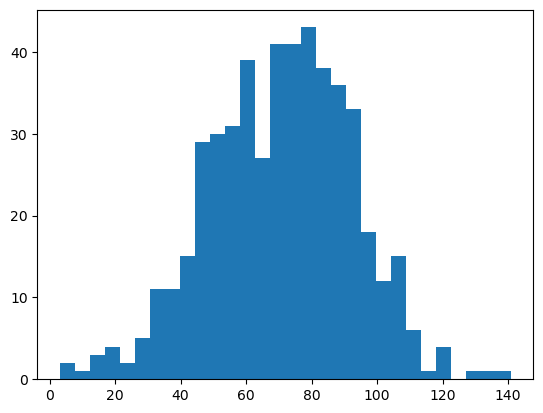

In [96]:
gym = df.loc[(df.Type=="TraditionalStrengthTraining")]
duration = gym['duration'].values

plt.hist(duration, bins=30)

In [97]:
df.columns

Index(['workoutActivityType', 'duration', 'durationUnit', 'creationDate',
       'startDate', 'endDate', 'Type', 'activeCalories', 'basalCalories',
       'distance', 'avgHeartRate', 'minHeartRate', 'maxHeartRate',
       'avgRunSpeed', 'minRunSpeed', 'maxRunSpeed', 'totalCalories'],
      dtype='object')

# average workouts per week 


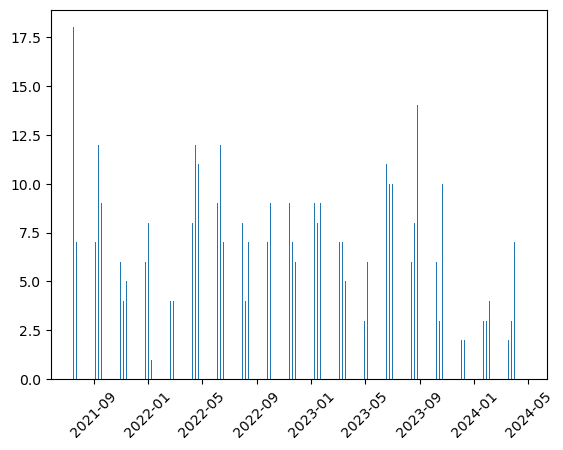

In [106]:
# average workouts per week 
# make creationDate the index
data = df.set_index('creationDate')
# resample by week 
workouts_per_week = data.resample('W').size()

# make a bar plot with weeks on the x-axis 
plt.bar(workouts_per_week.index, workouts_per_week.values)
plt.xticks(rotation=45)
plt.show()


In [107]:
workouts_per_week.mean()

6.848275862068966

# heart rate statistics 

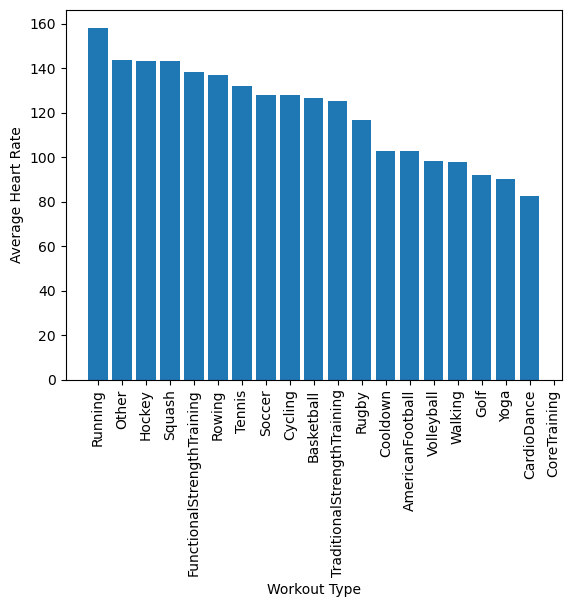

In [129]:
heart = df.groupby('Type')['avgHeartRate'].mean().sort_values(ascending=False)

plt.bar(heart.index, heart.values, label="Total")
plt.xlabel('Workout Type')
plt.ylabel('Average Heart Rate')
plt.xticks(rotation=90)
# plt.legend()

plt.show()

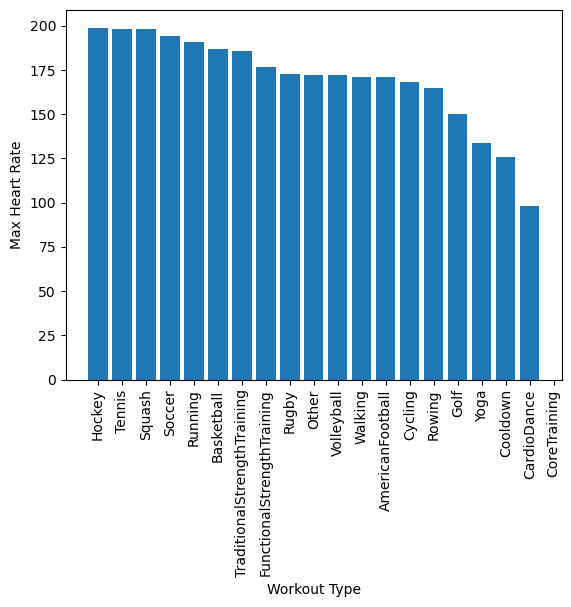

In [130]:
# which exercise has the highest heart rate
max_heart = df.groupby('Type')['maxHeartRate'].max().sort_values(ascending=False)

plt.bar(max_heart.index, max_heart.values, label="Total")
plt.xlabel('Workout Type')
plt.ylabel('Max Heart Rate')
plt.xticks(rotation=90)
# plt.legend()

plt.show()

In [131]:
df.columns

Index(['workoutActivityType', 'duration', 'durationUnit', 'creationDate',
       'startDate', 'endDate', 'Type', 'activeCalories', 'basalCalories',
       'distance', 'avgHeartRate', 'minHeartRate', 'maxHeartRate',
       'avgRunSpeed', 'minRunSpeed', 'maxRunSpeed', 'totalCalories'],
      dtype='object')

# check the correlation between calories and heart rate

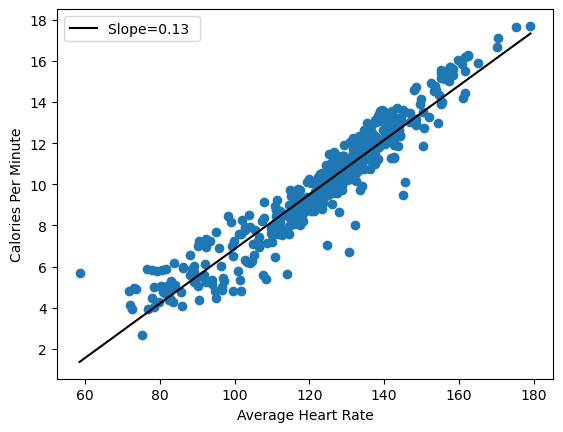

In [159]:
# scatter plot for average heart rate vs total calories burned
plt.scatter(df['avgHeartRate'], df['totalCalories']/df['duration'])

clean_df = df.dropna(subset=['avgHeartRate', 'totalCalories', 'duration'])

# do a best fit line and print the slop 
def line_of_best_fit(x,a,b):
    return a*x + b

x_data = clean_df['avgHeartRate'].values
y_data = (clean_df['totalCalories'] / clean_df['duration']).values
params, covariance = curve_fit(line_of_best_fit, x_data,  y_data)
m_fit, b_fit = params 

x = np.linspace(x_data.min(), x_data.max())
y_fit = line_of_best_fit(x, m_fit, b_fit)

plt.plot(x, y_fit, color='k', label=f"Slope={m_fit:.2f} ")
plt.xlabel('Average Heart Rate')
plt.ylabel('Calories Per Minute')
plt.legend()
plt.show()

# print(m_fit, b_fit)


In [153]:
clean_df

,workoutActivityType,duration,durationUnit,creationDate,startDate,endDate,Type,activeCalories,basalCalories,distance,avgHeartRate,minHeartRate,maxHeartRate,avgRunSpeed,minRunSpeed,maxRunSpeed,totalCalories
474,HKWorkoutActivityTypeTraditionalStrengthTraining,85.082387,min,2022-11-10 22:48:13-04:00,2022-11-10 21:22:59-04:00,2022-11-10 22:48:04-04:00,TraditionalStrengthTraining,659.5070,141.6260,NaN,122.703,89.0,168.0,NaN,NaN,NaN,801.1330
475,HKWorkoutActivityTypeTraditionalStrengthTraining,34.708990,min,2022-11-11 19:19:55-04:00,2022-11-11 18:45:08-04:00,2022-11-11 19:19:50-04:00,TraditionalStrengthTraining,292.6980,57.3501,NaN,123.747,67.0,168.0,NaN,NaN,NaN,350.0481
476,HKWorkoutActivityTypeTraditionalStrengthTraining,58.601845,min,2022-11-12 19:15:21-04:00,2022-11-12 18:16:38-04:00,2022-11-12 19:15:14-04:00,TraditionalStrengthTraining,623.4030,98.6884,NaN,137.675,87.0,169.0,NaN,NaN,NaN,722.0914
477,HKWorkoutActivityTypeTraditionalStrengthTraining,64.151372,min,2022-11-13 22:00:03-04:00,2022-11-13 20:55:48-04:00,2022-11-13 21:59:57-04:00,TraditionalStrengthTraining,341.5720,104.5060,NaN,106.629,79.0,141.0,NaN,NaN,NaN,446.0780
478,HKWorkoutActivityTypeWalking,13.121180,min,2022-11-13 22:13:25-04:00,2022-11-13 22:00:15-04:00,2022-11-13 22:13:22-04:00,Walking,96.7022,22.1601,0.757023,126.137,94.0,146.0,NaN,NaN,NaN,118.8623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,HKWorkoutActivityTypeTennis,77.046009,min,2024-04-14 18:33:33-04:00,2024-04-14 17:16:22-04:00,2024-04-14 18:33:25-04:00,Tennis,830.8660,126.4930,3.122050,137.097,85.0,166.0,NaN,NaN,NaN,957.3590
989,HKWorkoutActivityTypeWalking,26.836653,min,2024-04-15 13:27:04-04:00,2024-04-15 13:00:09-04:00,2024-04-15 13:26:59-04:00,Walking,124.5880,44.0505,2.220820,104.589,84.0,125.0,NaN,NaN,NaN,168.6385
990,HKWorkoutActivityTypeWalking,32.025973,min,2024-04-15 17:07:28-04:00,2024-04-15 16:35:22-04:00,2024-04-15 17:07:24-04:00,Walking,115.5180,52.5988,2.130060,89.140,64.0,105.0,NaN,NaN,NaN,168.1168
991,HKWorkoutActivityTypeTraditionalStrengthTraining,93.171743,min,2024-04-15 21:27:32-04:00,2024-04-15 19:54:14-04:00,2024-04-15 21:27:24-04:00,TraditionalStrengthTraining,982.5790,151.3140,NaN,138.461,97.0,184.0,NaN,NaN,NaN,1133.8930


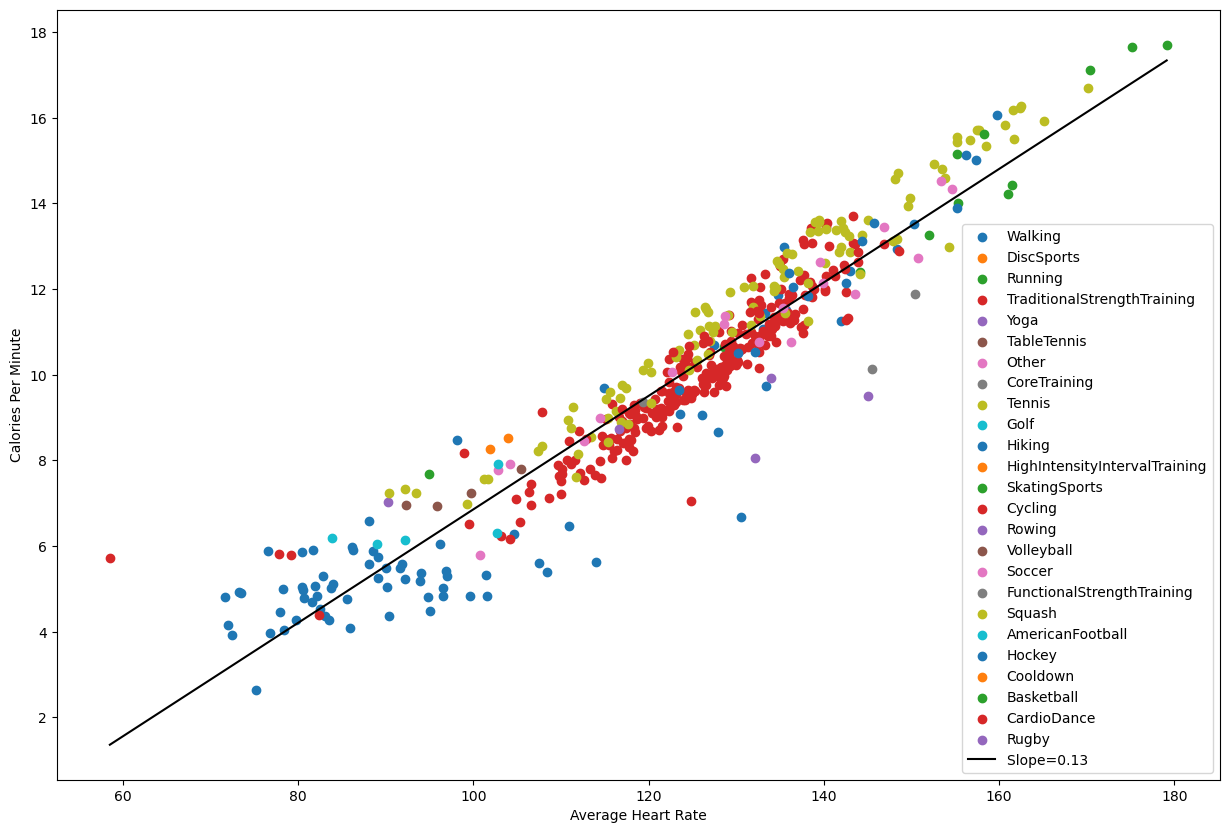

In [160]:
# same but by exercise 
plt.figure(figsize=(15, 10))
for exercise in df.Type.unique():
    data = df[df.Type == exercise]
    plt.scatter(data['avgHeartRate'], data['totalCalories']/data['duration'], label=exercise)

plt.plot(x, y_fit, color='k', label=f"Slope={m_fit:.2f} ")
plt.xlabel('Average Heart Rate')
plt.ylabel('Calories Per Minute')

plt.legend()
plt.show()

# look at improvement in running 

In [169]:
running = df.query('Type=="Running"')
start_date = pd.to_datetime('2023-01-01').tz_localize('UTC-04:00')
end_date = pd.to_datetime('2024-01-01').tz_localize('UTC-04:00')

filtered_running = running[(running['creationDate'] >= start_date) & (running['creationDate'] <= end_date)]

/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_48128/4072518322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_running['Pace'] = filtered_running['duration'] / filtered_running['distance']


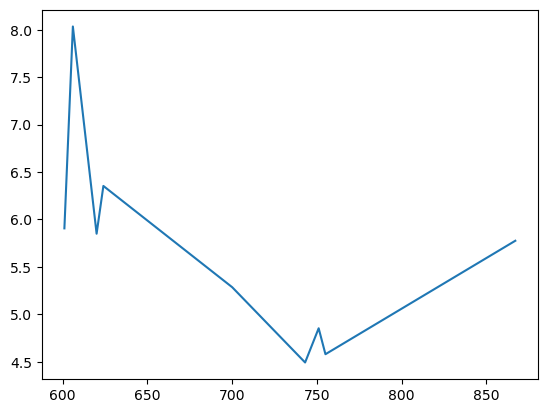

In [172]:
filtered_running['Pace'] = filtered_running['duration'] / filtered_running['distance']
plt.plot(filtered_running['Pace'])

In [175]:
filtered_running

,workoutActivityType,duration,durationUnit,creationDate,startDate,endDate,Type,activeCalories,basalCalories,distance,avgHeartRate,minHeartRate,maxHeartRate,avgRunSpeed,minRunSpeed,maxRunSpeed,totalCalories,Pace
601,HKWorkoutActivityTypeRunning,20.736096,min,2023-03-11 11:54:12-04:00,2023-03-11 11:33:19-04:00,2023-03-11 11:54:03-04:00,Running,264.901,34.0977,3.51076,161.507,146.0,172.0,10.22020,5.352080,12.1665,298.9987,5.906441
606,HKWorkoutActivityTypeRunning,16.209052,min,2023-03-19 17:56:24-04:00,2023-03-19 17:40:08-04:00,2023-03-19 17:56:21-04:00,Running,146.062,26.6716,2.01734,128.594,92.0,150.0,NaN,NaN,NaN,172.7336,8.034864
620,HKWorkoutActivityTypeRunning,21.976711,min,2023-04-03 08:56:47-04:00,2023-04-03 08:34:41-04:00,2023-04-03 08:56:40-04:00,Running,276.267,36.0172,3.75665,160.983,126.0,172.0,10.27430,4.501450,12.0483,312.2842,5.850082
624,HKWorkoutActivityTypeRunning,21.412219,min,2023-04-09 09:04:35-04:00,2023-04-09 08:43:04-04:00,2023-04-09 09:04:29-04:00,Running,230.084,35.1700,3.37005,144.129,110.0,177.0,9.45753,3.908540,13.3587,265.2540,6.353680
700,HKWorkoutActivityTypeRunning,13.832930,min,2023-06-04 18:18:26-04:00,2023-06-04 18:04:30-04:00,2023-06-04 18:18:20-04:00,Running,186.851,22.7231,2.61693,155.216,127.0,169.0,11.32670,5.343960,13.1107,209.5741,5.285938
743,HKWorkoutActivityTypeRunning,11.769828,min,2023-07-02 18:01:08-04:00,2023-07-02 17:49:14-04:00,2023-07-02 18:01:01-04:00,Running,182.060,19.2701,2.61983,170.406,123.0,181.0,13.44110,4.453250,15.3286,201.3301,4.492592
751,HKWorkoutActivityTypeRunning,17.510859,min,2023-07-05 16:47:19-04:00,2023-07-05 16:29:42-04:00,2023-07-05 16:47:13-04:00,Running,280.356,28.7275,3.60809,175.115,113.0,187.0,12.40230,4.250360,13.1717,309.0835,4.853221
755,HKWorkoutActivityTypeRunning,22.236930,min,2023-07-09 09:22:30-04:00,2023-07-09 09:00:08-04:00,2023-07-09 09:22:22-04:00,Running,357.222,36.4676,4.85553,179.122,121.0,191.0,13.63420,1.991080,15.8239,393.6896,4.579712
867,HKWorkoutActivityTypeRunning,30.824495,min,2023-10-03 17:39:30-04:00,2023-10-03 17:08:33-04:00,2023-10-03 17:39:22-04:00,Running,380.862,50.6100,5.33682,155.357,111.0,173.0,10.75810,0.302695,16.4005,431.4720,5.775817


# look at activity 

In [5]:
activity = load_dataframe('ActivitySummary')

In [6]:
activity

,dateComponents,activeEnergyBurned,activeEnergyBurnedGoal,activeEnergyBurnedUnit,appleMoveTime,appleMoveTimeGoal,appleExerciseTime,appleExerciseTimeGoal,appleStandHours,appleStandHoursGoal
0,2021-05-13,0,0,Cal,0,0,0,30,0,12
1,2021-05-14,3.141,0,Cal,0,0,0,30,0,12
2,2021-07-11,0,0,Cal,0,0,0,30,0,12
3,2021-07-12,480.135,650,Cal,0,0,63,45,4,6
4,2021-07-13,1421.75,650,Cal,0,0,142,45,15,6
...,...,...,...,...,...,...,...,...,...,...
975,2024-04-12,668.455,1200,Cal,0,0,37,90,12,8
976,2024-04-13,481.162,1200,Cal,0,0,30,90,9,8
977,2024-04-14,1285.54,1200,Cal,0,0,109,90,12,8
978,2024-04-15,1481.24,1200,Cal,0,0,159,90,11,8


In [7]:
# look at the number of days activeEnergyBurned is greater than activeEnergyBurnedGoal
activity['activeEnergyBurned'] = pd.to_numeric(activity['activeEnergyBurned'])
activity['activeEnergyBurnedGoal'] = pd.to_numeric(activity['activeEnergyBurnedGoal'])

(activity['activeEnergyBurned'] > activity['activeEnergyBurnedGoal']).sum() / len(activity) * 100

57.14285714285714

In [26]:
table = PrettyTable()
table.field_names = ["Goal", "Percent Achieved"]
table.add_row(["Calories", "%.2f" %((activity['activeEnergyBurned'] > activity['activeEnergyBurnedGoal']).sum() / len(activity) * 100) + '%'])
table.add_row(["Exercise", "%.2f" %((activity['appleExerciseTime'] > activity['appleExerciseTimeGoal']).sum() / len(activity) * 100)+ '%'])
table.add_row(["Stand", "%.2f" %((activity['appleStandHours'] > activity['appleStandHoursGoal']).sum() / len(activity) * 100)+ '%'])

# Add some style
# table.align = "l"
# table.border = True
# table.padding_width = 1

# Print the table
print(table)

+----------+------------------+
|   Goal   | Percent Achieved |
+----------+------------------+
| Calories |      51.43%      |
| Exercise |      32.86%      |
|  Stand   |      14.59%      |
+----------+------------------+


# Plot for all workouts as a function of calories burned and duration

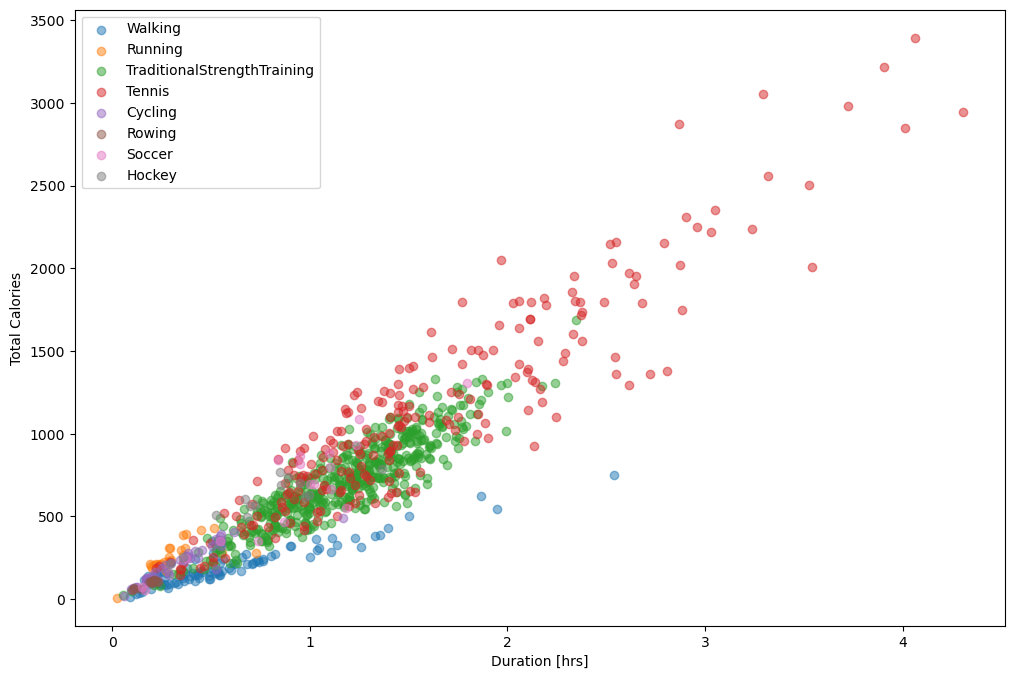

In [31]:
plt.figure(figsize=(12,8))
for workout in df.Type.unique():
    data = df[df.Type == workout]
    if len(data) < 10:
        continue
    cals = data['totalCalories']
    dur = data['duration'] / 60 
        
    plt.scatter(dur, cals, label=workout, alpha=0.5)

plt.xlabel('Duration [hrs]')
plt.ylabel('Total Calories')
plt.legend()
plt.show()

# K means clustering

/Users/adamsmith/opt/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/71/rd8s6g0x52sd1l6wnf9_z6_r0000gn/T/ipykernel_54167/4277728570.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(principal_components[:, 0], principal_components[:, 1], cmap='viridis', marker='o', alpha=0.5)


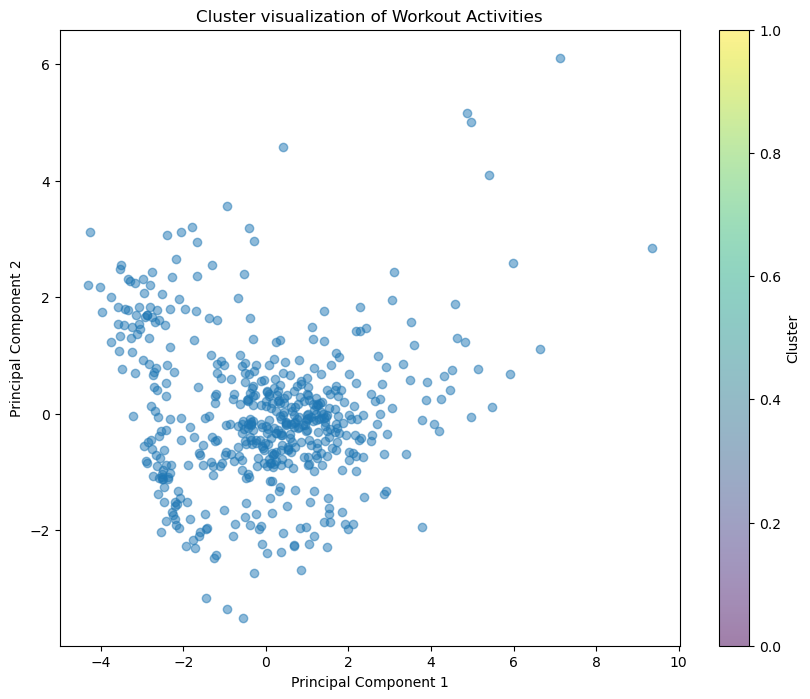

In [24]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA

# # Assuming df is your DataFrame
# # Select numeric columns that are relevant for clustering
# features = df[['duration', 'activeCalories', 'basalCalories', 'avgHeartRate', 'maxHeartRate', 'totalCalories']]

# # Handle missing values, for simplicity let's drop them
# features = features.dropna()

# # Scale the features
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

# # Create a k-means model with k clusters
# k = 5
# kmeans = KMeans(n_clusters=k, random_state=42)
# kmeans.fit(features_scaled)

# # Assign clusters back to the main DataFrame
# features['Cluster'] = kmeans.labels_

# # Reduce dimensions to 2D for visualization using PCA
# pca = PCA(n_components=2)
# principal_components = pca.fit_transform(features_scaled)

# # Create a scatter plot of the two PCA components
# plt.figure(figsize=(10, 8))
# plt.scatter(principal_components[:, 0], principal_components[:, 1], cmap='viridis', marker='o', alpha=0.5)
# plt.title('Cluster visualization of Workout Activities')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.colorbar(label='Cluster')

# # # Optionally, annotate the points with some labels, e.g., workout types
# # for i, txt in enumerate(df['workoutActivityType']):
# #     plt.annotate(txt, (principal_components[i, 0], principal_components[i, 1]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, alpha=0.7)

# plt.show()

In [20]:
features

,duration,activeCalories,basalCalories,avgHeartRate,maxHeartRate,totalCalories
474,85.082387,659.5070,141.6260,122.703,168.0,801.1330
475,34.708990,292.6980,57.3501,123.747,168.0,350.0481
476,58.601845,623.4030,98.6884,137.675,169.0,722.0914
477,64.151372,341.5720,104.5060,106.629,141.0,446.0780
478,13.121180,96.7022,22.1601,126.137,146.0,118.8623
...,...,...,...,...,...,...
988,77.046009,830.8660,126.4930,137.097,166.0,957.3590
989,26.836653,124.5880,44.0505,104.589,125.0,168.6385
990,32.025973,115.5180,52.5988,89.140,105.0,168.1168
991,93.171743,982.5790,151.3140,138.461,184.0,1133.8930


# Insights dev

In [63]:
dates = activity.dateComponents.values.to_datetime()
dates

AttributeError: 'numpy.ndarray' object has no attribute 'to_datetime'

In [67]:
# convert string values to datetime 
dates = pd.to_datetime(activity.dateComponents.values)
dates

DatetimeIndex(['2021-05-13', '2021-05-14', '2021-07-11', '2021-07-12',
               '2021-07-13', '2021-07-14', '2021-07-15', '2021-07-16',
               '2021-07-17', '2021-07-18',
               ...
               '2024-04-07', '2024-04-08', '2024-04-09', '2024-04-10',
               '2024-04-11', '2024-04-12', '2024-04-13', '2024-04-14',
               '2024-04-15', '2024-04-16'],
              dtype='datetime64[ns]', length=980, freq=None)

In [73]:
len(dates.unique())

980

In [74]:
(dt.datetime.now - dates.min()).days

TypeError: unsupported operand type(s) for -: 'builtin_function_or_method' and 'Timestamp'

In [79]:
# find the number of days passed from today to dates.min()
(dt.datetime.now() - dates.min()).days

1075

In [80]:
len(activity)

980

In [87]:
len(pd.to_datetime(workouts.creationDate).unique())

993

In [92]:
len(pd.to_datetime(workouts.creationDate).dt.date.unique())

678

In [95]:
dates = pd.to_datetime(activity.dateComponents.values)
dates.min().date()

datetime.date(2021, 5, 13)

In [104]:
np.round(activity.appleExerciseTime.astype(float).sum()/60)

1345.0

In [111]:
dates

DatetimeIndex(['2021-05-13', '2021-05-14', '2021-07-11', '2021-07-12',
               '2021-07-13', '2021-07-14', '2021-07-15', '2021-07-16',
               '2021-07-17', '2021-07-18',
               ...
               '2024-04-07', '2024-04-08', '2024-04-09', '2024-04-10',
               '2024-04-11', '2024-04-12', '2024-04-13', '2024-04-14',
               '2024-04-15', '2024-04-16'],
              dtype='datetime64[ns]', length=980, freq=None)

In [116]:
value = 23.23
1 % value

1.0